Ben Ghertner 2025

Code to generate the dispersion relationship check against CM1 using the measure cloud edge motion.

    - Figure 3.9

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.fft import fft

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 11

%matplotlib inline

Inversion set-up parameters and dispersion + rootfinding methods

In [2]:
#These come from CM1 init3d_BLG.F inversionwave
N2t = 4.19864664E-05
N2i = 3.66779772E-04
N2c = 2.03111340E-04

#Nominal Cloud and Inversion Heights and Domain Top Height
Hc  = 300
Hi  = 600
HT = 1500

#evaluate dispersion relationship (finite domain) defined by Det(M) with M given in Eq (3.44)
# input:
#       c - wavespeed
#       k - wavenumber
# returns:
#       Det(M) from Eq (3.44)
def dispersion(c,k):
    mt = np.sqrt( (k**2 - N2t/c**2) )
    mi = np.sqrt( (N2i/c**2 - k**2) )
    mc = np.sqrt( (k**2 - N2c/c**2) )

    J_psia_Hi = np.sin(mi*Hi)*mt/np.tanh(mt*((Hi-HT))) - mi*np.cos(mi*Hi)
    J_psib_Hi = np.cos(mi*Hi)*mt/np.tanh(mt*((Hi-HT))) + mi*np.sin(mi*Hi)
    J_psia_Hc = mi*np.cos(mi*Hc) - np.sin(mi*Hc)*mc/np.tanh(mc*Hc)
    J_psib_Hc = -mi*np.sin(mi*Hc) - np.cos(mi*Hc)*mc/np.tanh(mc*Hc)

    return J_psia_Hi*J_psib_Hc - J_psib_Hi*J_psia_Hc

#Routine to root find the dispersion relationships
# input:
#       cguess     - current guess at the wavespeed
#       k          - wavenumber
# returns:
#       c          - Numerical solution to the root finding problem Det(M) = 0
def secant_solve(cguess, k):
    i = 0
    #initialize first guess
    c0 = cguess - 0.001
    c1 = cguess
    #iterate until tolerance reached
    while np.abs((c0-c1)/c1) > 1e-10:
        #Safety feature if method is not converging
        i += 1
        if i > 100:
            print('failed to converge')
            return
        #Save current best guess
        ctemp = c1
        #Secant step
        c1 = c1 - dispersion(c1,k)*(c1-c0)/(dispersion(c1,k) - dispersion(c0,k))
        #update last guess
        c0 = ctemp
        
    return c1

Measure Wavespeed based on interface location from CM1 runs.

In [3]:
#Hardcode array of k values cooresponding to CM1 runs
ksCM1 = np.array([2*np.pi/2500, 2*np.pi/1500, 2*np.pi/1000, 
                  2*np.pi/800, 2*np.pi/666, 2*np.pi/575, 
                  2*np.pi/500, 2*np.pi/450])
#Hardcode list file paths for each CM1 run
files = ['./cm1DispersionTest/domain_2500/cm1out.nc', './cm1DispersionTest/domain_1500/cm1out.nc',
         './cm1DispersionTest/domain_1000/cm1out.nc', './cm1DispersionTest/domain_800/cm1out.nc',
         './cm1DispersionTest/domain_666/cm1out.nc', './cm1DispersionTest/domain_575/cm1out.nc', 
         './cm1DispersionTest/domain_500/cm1out.nc', './cm1DispersionTest/domain_450/cm1out.nc']
#Initialize wave speed array
csCM1 = np.empty_like(ksCM1)

#Routine measure interface wavespeed from a CM1 run
#Note: I've been a bit sloppy. In my thesis I claimed we
#could do interpolation of the liquid water function
#but we need to compute analytic extensions of the cloudy
#r^star into the clear in order to do this. This code
#just does the simple extrapolation as in Walsh & Muraki (2024).
# input:
#       filename   - CM1 output filepath
#       k          - wavenumber
# returns:
#       c          - Measured wavespeed
def measure_c(filename, k):
    ds = xr.open_dataset(filename)
    zh = ds['zh'].to_numpy()
    rl = ds['ql'].to_numpy()[:,:,0,:]

    #time in CM1 is in nanoseconds for some reason - convert to seconds
    t = ds['time'].to_numpy().astype('float')/1.0e9

    Nt, Nz, Nx = rl.shape
    #initialize array of interface heights in time-space
    Zcm1 = np.zeros((Nt,Nx))

    #loop through time points
    for idt in range(Nt):
        #loop through horizontal space points
        for idx in range(Nx):
            #move up through vertical points until interface is found
            for idz in range(Nz):
                #Stop two shy of 0 water to extrapolate last two positive rl points
                if rl[idt,idz+2,idx] == 0:
                    #Linear extrapolation to find 0 rl level
                    rl1 = rl[idt,idz,idx]
                    rl2 = rl[idt,idz+1,idx]
                    m = (rl2 - rl1)/(zh[idz+1] - zh[idz])
                    Zcm1[idt,idx] = zh[idz] - rl1/m
                    break
    
    #Get fourier coefs for the interface height (this transforms the space dimension)
    Zhat = fft(Zcm1)
    #Phase of the first fourier component
    C1 = (np.log(Zhat[1:,1])).imag
    #correct branch cut
    C1 = np.where((C1 < 0), C1+2*np.pi, C1)
    #linear fit to get the phase speed
    om, _ = np.polyfit(t[1:-1], -C1[:-1], 1)
    return om/k

#loop through CM1 files
for idx in range(ksCM1.size):
    csCM1[idx] = measure_c(files[idx], ksCM1[idx])

/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_63612/4152862745.py:25: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(filename)
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_63612/4152862745.py:25: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(filename)
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_63612/4152862745.py:25: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(filename)
/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel

Compute the cut-off values of $k$ and $c$ for the finite domain

In [4]:
#Hard code first guesses needs to be somewhat close
#Long wave cut off
k_limit = 2*np.pi/5000
c_limit = 5.9 + 0j
#evanescent/wave in cloud cut-off
k_cld   = 2*np.pi/1500
c_cld   = 3.0 + 0j

#Long wave cute off is the root of the vertical wavenumber in the top region
calc_mt = lambda k,c: (k**2 - N2t/c**2)

i = 0
#initialize first guess
k0 = k_limit*(1.01)
k1 = k_limit
while np.abs((k0-k1)/k1) > 1e-8:
    #fail safe for failed convergence
    i += 1
    if i > 100:
        print('failed to converge')
        break
    #save current best guess
    ktemp = k1
    #compute wavespeeds associated with current guess at k
    c0 = secant_solve(c_limit, k0)
    c1 = secant_solve(c_limit, k1)
    #secant step
    k1 = k1 - calc_mt(k1,c1)*(k1-k0)/(calc_mt(k1,c1) - calc_mt(k0,c0))
    #update last guess
    k0 = ktemp

k_limit = k1

#evanescent in cloud cut-off is the root of the vertical wavenumber in the cloud
calc_mc = lambda k,c: (k**2 - N2c/c**2)

i = 0
#initialize first guess
k0 = k_cld*(1.01)
k1 = k_cld
while np.abs((k0-k1)/k1) > 1e-8:
    #fail safe for failed convergence
    i += 1
    if i > 100:
        print('failed to converge')
        break
    #save current best guess
    ktemp = k1
    #compute wavespeeds associated with current guess at k
    c0 = secant_solve(c_cld, k0)
    c1 = secant_solve(c_cld, k1)
    #secant step
    k1 = k1 - calc_mc(k1,c1)*(k1-k0)/(calc_mc(k1,c1) - calc_mc(k0,c0))
    #update last guess
    k0 = ktemp
    
k_cld = k1

**Figure 3.9**

/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


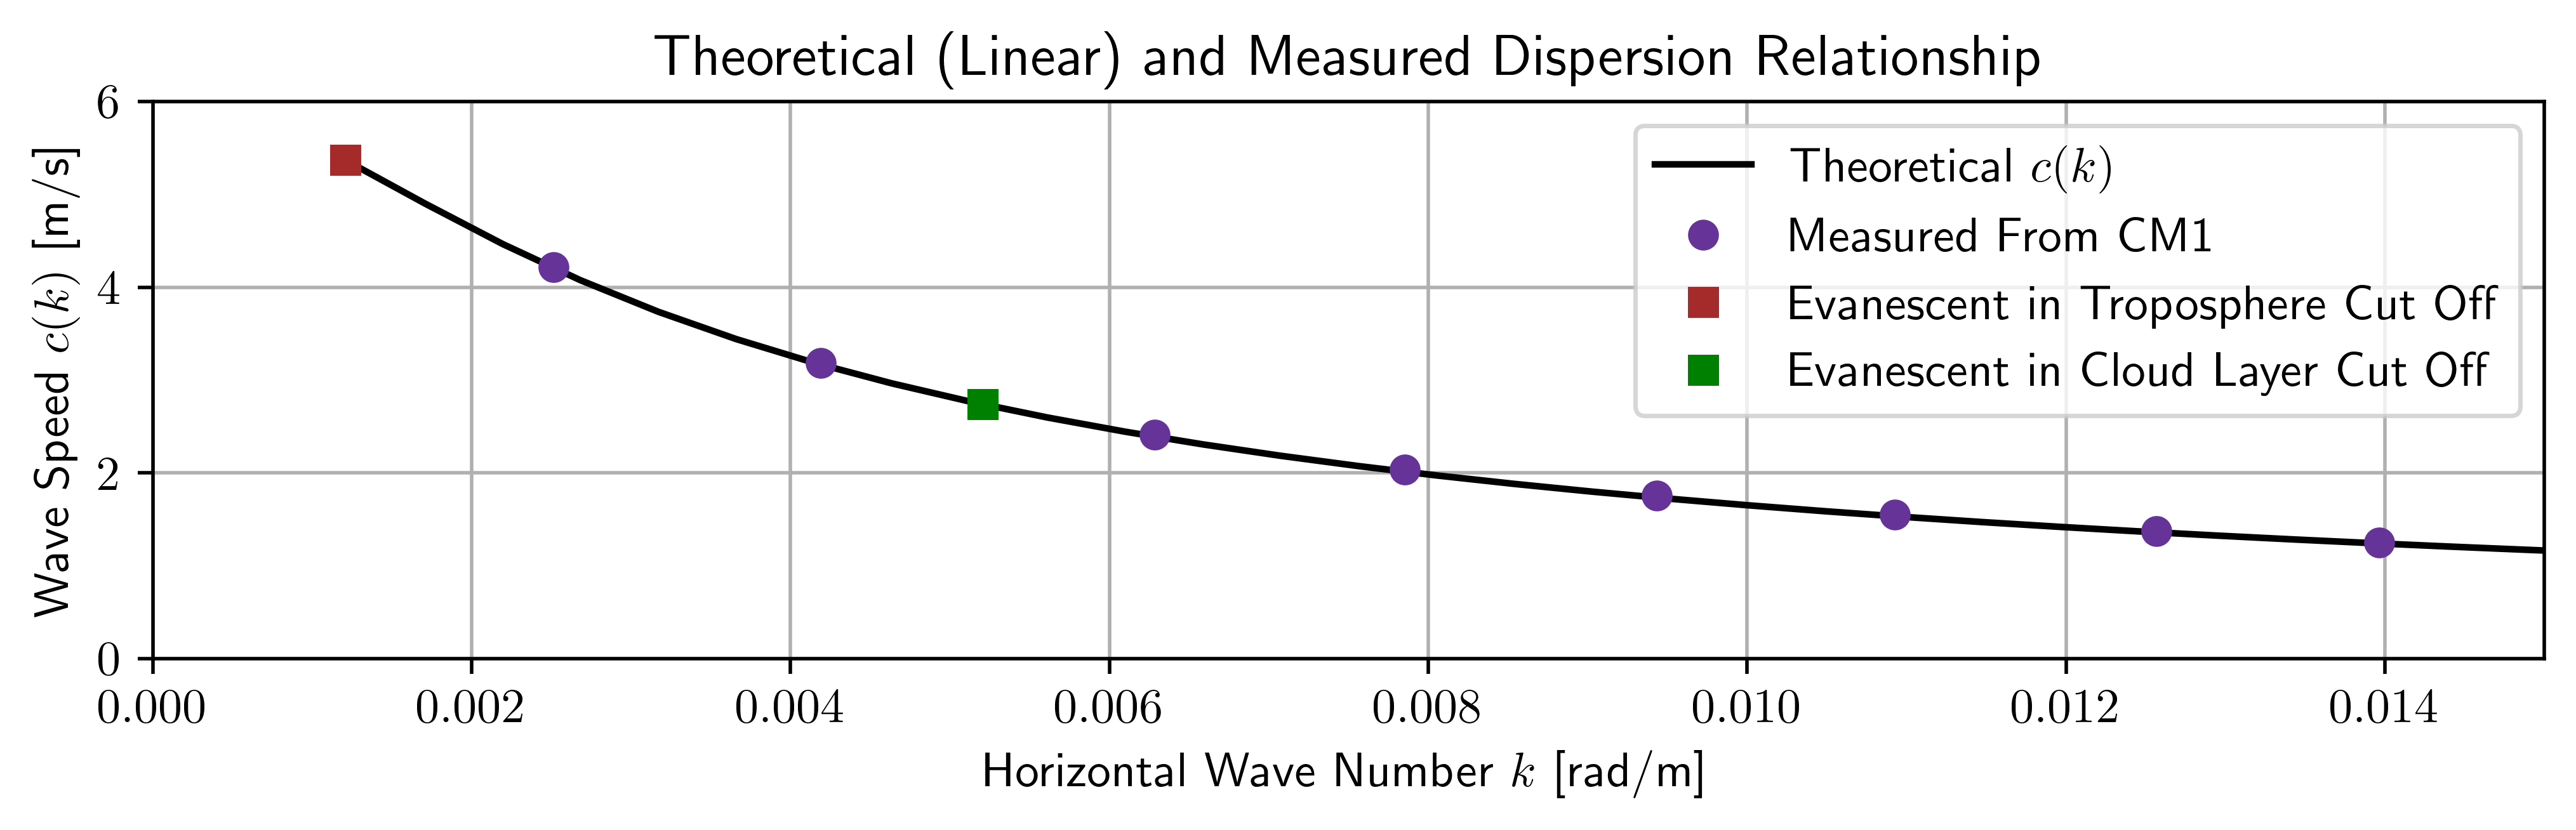

In [5]:
#Wavenumbers for the theorectical (linear) dispersion relationship curve
ks = np.linspace(k_limit*1.01, 2*np.pi/250)
#Initialize array for theoretical wavespeeds
cs = np.empty_like(ks)

#Loop through wavenumbers and compute wavespeeds
for idx in range(ks.size):
    k = ks[idx]
    if idx == 0: c_guess = 5.9+0.0j
    else:        c_guess = cs[idx-1]
    cs[idx] = secant_solve(c_guess+0j, k).real

#Plotting
fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(8, 2.5)
fig.set_dpi(500)

ax.plot(ks, cs, color='k', label=r'Theoretical $c(k)$')
ax.plot(ksCM1, csCM1, 'o', color='rebeccapurple', label=r'Measured From CM1')
ax.plot(k_limit, secant_solve(5.9+0.0j, k_limit), 's', color='brown', label='Evanescent in Troposphere Cut Off')
ax.plot(k_cld, secant_solve(2.5+0.0j, k_cld), 'sg', label='Evanescent in Cloud Layer Cut Off')
ax.grid()
ax.legend()
ax.set(xlim=(0.0, 0.015), ylim=(0.0, 6.))
ax.set(xlabel=r'Horizontal Wave Number $k$ [rad/m]', ylabel=r'Wave Speed $c(k)$ [m/s]')
ax.set(title=r'Theoretical (Linear) and Measured Dispersion Relationship')

plt.show()